<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    <b>RNN Sentiment Analysis</b>
</div>

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Importing Libraries
</div>

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk import ngrams
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
plt.style.use('fivethirtyeight')
color = ['#E36149', '#49AF72']
color_palette = ["#C30708", "#2E7D32"] 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    <b>Loading Dataset</b>
</div>

In [7]:
df = pd.read_csv('/kaggle/input/vs-sentiment-analysis/Beginner_Reviews_dataset.csv')
pd.set_option('display.max_colwidth', None)

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    <b>Basic Data Exploration</b>
</div>

In [8]:
df.head()

,Unnamed: 0,sentence,label
0,0,Wow... Loved this place.,1
1,1,Crust is not good.,0
2,2,Not tasty and the texture was just nasty.,0
3,3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,4,The selection on the menu was great and so were the prices.,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   sentence    1000 non-null   object
 2   label       1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [11]:
df.isna().sum()

Unnamed: 0    0
sentence      0
label         0
dtype: int64

In [13]:
df.duplicated().sum()

0

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Data Cleaning
</div>

In [14]:
df['label'] = df['label'].astype('category')

In [15]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [16]:
df['sentence'].head(20)

0                                                                                            Wow... Loved this place.
1                                                                                                  Crust is not good.
2                                                                           Not tasty and the texture was just nasty.
3                             Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
4                                                         The selection on the menu was great and so were the prices.
5                                                                      Now I am getting angry and I want my damn pho.
6                                                                               Honeslty it didn't taste THAT fresh.)
7     The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.
8                                                       

In [17]:
re.sub(r'[^A-Za-z0-9\s]+', '', 'Wow... Loved this place.')

'Wow Loved this place'

In [22]:
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]+', '', text)
def lower_case(text):
    return text.lower()

In [21]:
df['sentence'] = df['sentence'].apply(remove_special_characters)
df['sentence'] = df['sentence'].apply(lower_case)
df['sentence'].head()

0                                                                      wow loved this place
1                                                                         crust is not good
2                                                  not tasty and the texture was just nasty
3    stopped by during the late may bank holiday off rick steve recommendation and loved it
4                                the selection on the menu was great and so were the prices
Name: sentence, dtype: object

In [23]:
df['sentence'].sample(20)

620                                                                                                   i had the chicken pho and it tasted very bland
43                                                                       on a positive note our server was very attentive and provided great service
636                                                                                                 tried to go here for lunch and it was a madhouse
241                                                                                                               now this dish was quite flavourful
467    this is was due to the fact that it took 20 minutes to be acknowledged then another 35 minutes to get our foodand they kept forgetting things
315                                                                                                        the bus boy on the other hand was so rude
330                                                           the servers are not pleasant to deal with an

In [24]:
sentence_with_stopwords = 'i personally love the hummus pita baklava falafels and baba ganoush its amazing what they do with eggplant'
clean_words = ''
for word in sentence_with_stopwords.split():
    if word not in stopwords.words('english'):
        clean_words += ' ' + word

print(clean_words)

 personally love hummus pita baklava falafels baba ganoush amazing eggplant


In [25]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [26]:
df['sentence'].head(10)

0                                                                                              wow loved this place
1                                                                                                 crust is not good
2                                                                          not tasty and the texture was just nasty
3                            stopped by during the late may bank holiday off rick steve recommendation and loved it
4                                                        the selection on the menu was great and so were the prices
5                                                                     now i am getting angry and i want my damn pho
6                                                                                honeslty it didnt taste that fresh
7    the potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer
8                                                                       

In [27]:
nlp = spacy.load('en_core_web_sm')
sentence = 'potatoes like rubber could tell made ahead time kept warmer'
doc = nlp(sentence)
lemmatized_sentence = ' '.join([token.lemma_ for token in doc])
print(lemmatized_sentence)

potato like rubber could tell make ahead time keep warmer


In [28]:
def lemmatize_sentence(text):
    doc = nlp(text)
    lemmatized_sentence = ' '.join([token.lemma_ for token in doc])
    return lemmatized_sentence

In [29]:
df['sentence'] = df['sentence'].apply(lemmatize_sentence)

In [30]:
df['sentence'].head(10)

0                                                                                       wow love this place
1                                                                                         crust be not good
2                                                                   not tasty and the texture be just nasty
3                        stop by during the late may bank holiday off rick steve recommendation and love it
4                                                    the selection on the menu be great and so be the price
5                                                                 now I be get angry and I want my damn pho
6                                                                       honeslty it do not taste that fresh
7    the potato be like rubber and you could tell they have be make up ahead of time be keep under a warmer
8                                                                                      the fry be great too
9                           

In [31]:
df['sentence'] = df['sentence'].apply(remove_stopwords)

In [32]:
df.head()

,sentence,label
0,wow love place,1
1,crust good,0
2,tasty texture nasty,0
3,stop late may bank holiday rick steve recommendation love,1
4,selection menu great price,1


In [33]:
df.duplicated().sum()

15

In [35]:
df.drop_duplicates(inplace = True)

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Exploratory Data Analysis
</div>

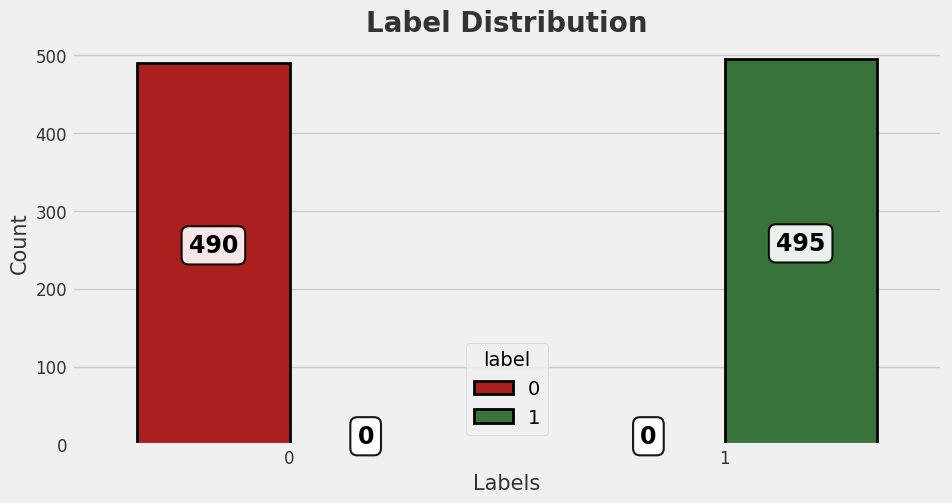

In [43]:
background_color = '#f0f0f0'
plt.figure(figsize=(10, 5), facecolor=background_color)
sns.set_palette("pastel")
p = sns.countplot(x="label", data=df, edgecolor='black', linewidth=2, width=0.7, palette = color_palette, hue="label")

for container in p.containers:
    p.bar_label(container, label_type="center", color="black", fontsize=17, weight='bold', padding=6, 
                bbox={"boxstyle": "round", "pad": 0.3, "facecolor": "white", "edgecolor": "black", "linewidth": 1.5, "alpha": 0.9})


plt.title("Label Distribution", fontweight='bold', fontsize=20, color='#333333')
plt.ylabel("Count", fontsize=15, color='#333333')
plt.xlabel("Labels", fontsize=15, color='#333333')

p.set_facecolor(background_color)
p.tick_params(colors='#333333', labelsize=12)

plt.show()

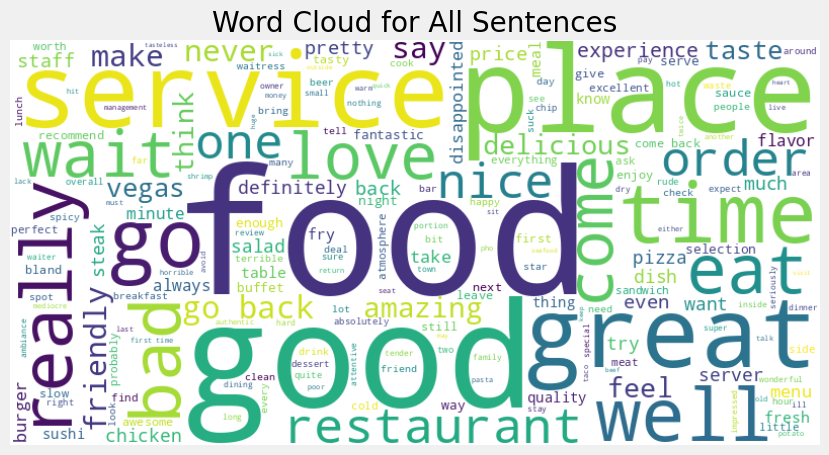

In [44]:
all_text = ' '.join(df['sentence'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Sentences')
plt.axis('off')
plt.show()

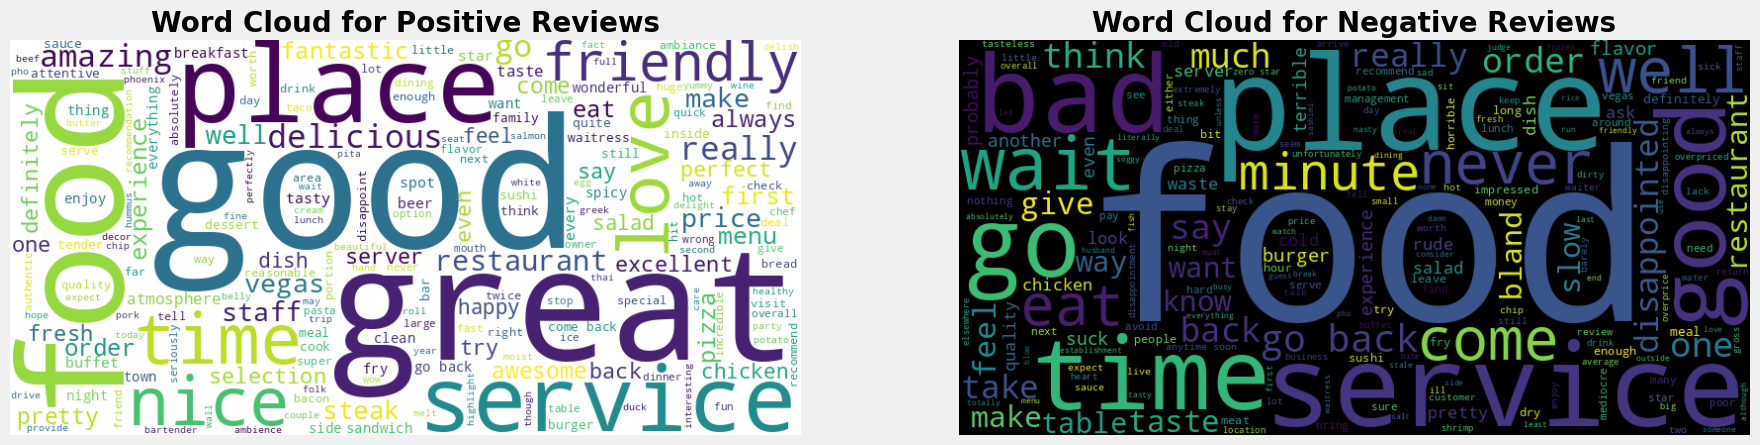

In [45]:
positive_text = ' '.join(df[df['label'] == 1]['sentence'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

negative_text = ' '.join(df[df['label'] == 0]['sentence'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews', fontsize=20, fontweight = 'bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews', fontsize=20, fontweight = 'bold')
plt.axis('off')

plt.show()

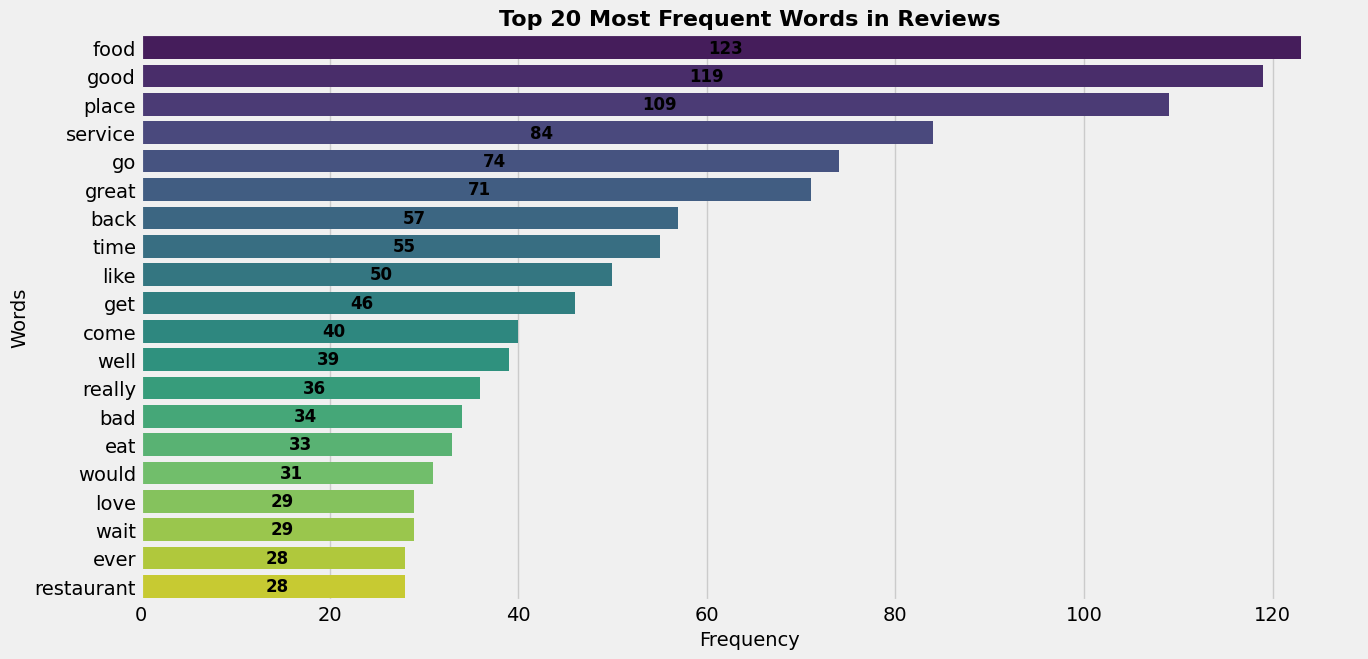

In [46]:
reviews = df['sentence']
positive_text = ' '.join(reviews)
positive_words = positive_text.split()
word_freq = Counter(positive_words)

most_common_words = word_freq.most_common(20)
common_words_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

plt.figure(figsize=(14, 7))
p = sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')

for container in p.containers:
    p.bar_label(container, label_type='center', color='black', fontsize=12, weight='bold', padding=3, fmt='%d')

plt.title('Top 20 Most Frequent Words in Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.show()

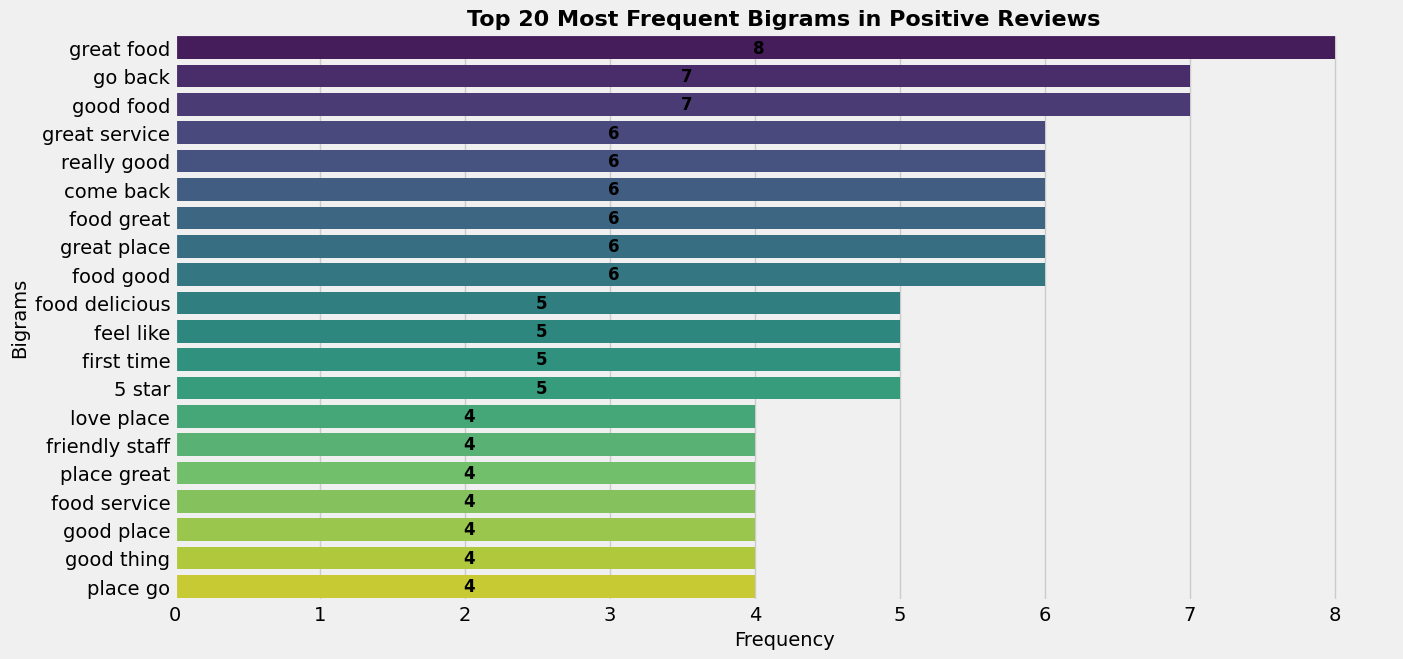

In [47]:
positive_reviews = df[df['label'] == 1]['sentence']
positive_text = ' '.join(positive_reviews)
positive_words = positive_text.split()
positive_bigrams = list(ngrams(positive_words, 2))

bigram_freq = Counter(positive_bigrams)

most_common_bigrams = bigram_freq.most_common(20)
common_bigrams_df = pd.DataFrame(most_common_bigrams, columns=['bigram', 'count'])
common_bigrams_df['bigram'] = common_bigrams_df['bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(14, 7))
p = sns.barplot(x='count', y='bigram', data=common_bigrams_df, palette='viridis')
for container in p.containers:
    p.bar_label(container, label_type='center', color='black', fontsize=12, weight='bold', padding=3, fmt='%d')

plt.title('Top 20 Most Frequent Bigrams in Positive Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)
plt.show()

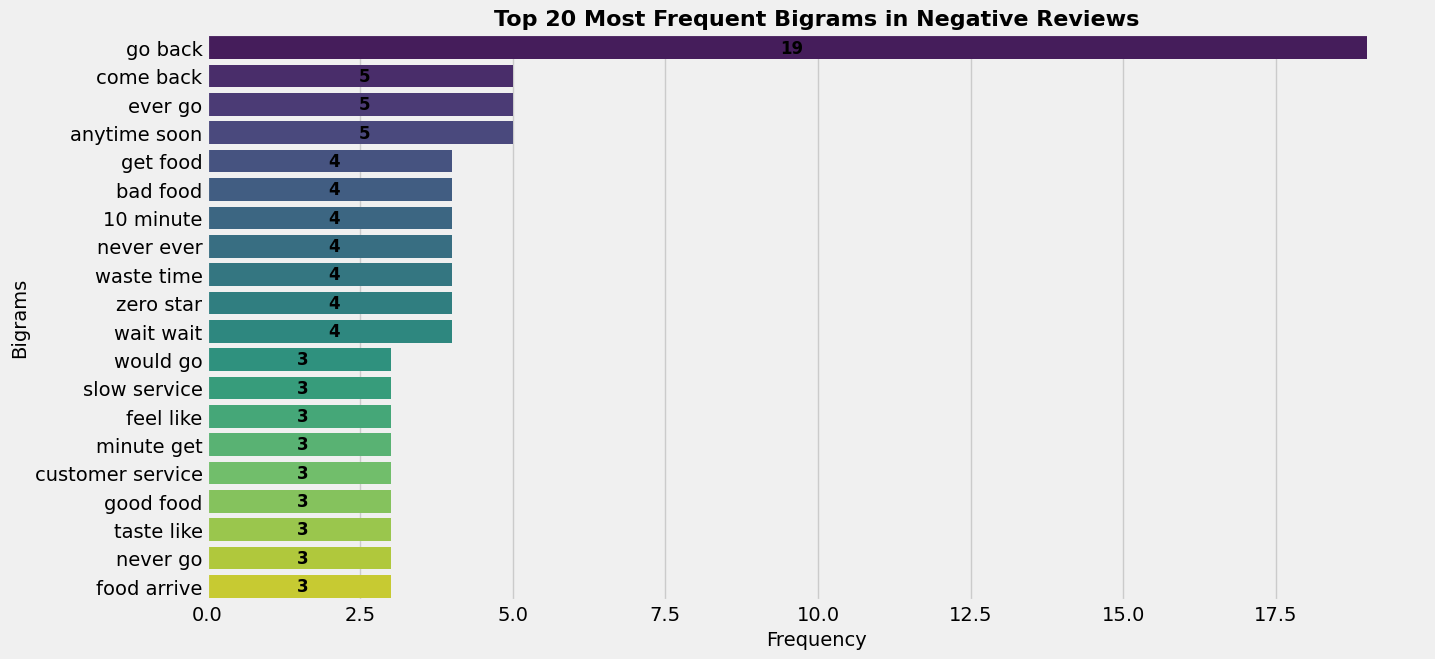

In [48]:
positive_reviews = df[df['label'] == 0]['sentence']
positive_text = ' '.join(positive_reviews)
positive_words = positive_text.split()
positive_bigrams = list(ngrams(positive_words, 2))

bigram_freq = Counter(positive_bigrams)

most_common_bigrams = bigram_freq.most_common(20)
common_bigrams_df = pd.DataFrame(most_common_bigrams, columns=['bigram', 'count'])
common_bigrams_df['bigram'] = common_bigrams_df['bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(14, 7))
p = sns.barplot(x='count', y='bigram', data=common_bigrams_df, palette='viridis')
for container in p.containers:
    p.bar_label(container, label_type='center', color='black', fontsize=12, weight='bold', padding=3, fmt='%d')

plt.title('Top 20 Most Frequent Bigrams in Negative Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)
plt.show()

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Data Preprocessing & Datra Normalization
</div>

In [49]:
df['sentence'] = df['sentence'].apply(remove_special_characters)

In [50]:
df[df['sentence'] == '']

,sentence,label
140,,0


In [51]:
df.drop(df[df['sentence'] == ''].index, inplace = True)

x = df['sentence'].values
y = df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

tokenizer = Tokenizer(oov_token="<oov>")
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

In [52]:
list(word_index)[:10]

['<oov>',
 'good',
 'food',
 'place',
 'service',
 'go',
 'great',
 'like',
 'get',
 'time']

In [53]:
len(word_index)

1452

In [54]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train[:10]

[[587, 200, 372, 155],
 [7, 10, 130, 106, 588, 79],
 [7, 5, 3],
 [80, 589, 131, 590],
 [20, 156, 373, 3, 40, 374, 591, 269, 375, 41, 81, 376, 132, 54, 4],
 [7, 201, 107],
 [108, 55],
 [202, 203],
 [23, 23, 23],
 [204, 8, 2, 157, 4, 592, 205, 377, 593, 3, 594, 82, 270]]

In [55]:
sequence_lengths = [len(seq) for seq in x_train]

# Find the minimum and maximum lengths
min_length = min(sequence_lengths)
max_length = max(sequence_lengths)

print(f"Minimum sequence length: {min_length}")
print(f"Maximum sequence length: {max_length}")

Minimum sequence length: 1
Maximum sequence length: 18


In [56]:
error_sentences = df[df['sentence'].apply(lambda x: len(x.split()) < 2)]

print("Rows with sentences having fewer than 2 words:")
print(error_sentences)

Rows with sentences having fewer than 2 words:
          sentence label
19            like     0
24         perform     1
83           place     1
96            back     1
98            good     0
115          check     1
165      delicious     1
272           beat     1
278          think     0
326     disappoint     1
351       terrible     0
380           back     0
388       disgrace     0
424        mistake     0
425      complaint     1
453       insulted     0
479           love     1
489        awesome     1
581           rate     0
609            eat     0
619         return     0
621  disappointing     0
663          great     1
670             go     0
697        mortify     0
711          thing     0
764          happy     1
813           pack     0
834      excellent     1
911            sad     0
947   disappointed     0


In [57]:
maxlen = 20
x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen, truncating = 'post')
x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen, truncating = 'post')

x_train[4]

array([ 20, 156, 373,   3,  40, 374, 591, 269, 375,  41,  81, 376, 132,
        54,   4,   0,   0,   0,   0,   0], dtype=int32)

In [58]:
len(x_train[0])

20

In [59]:
x_train.shape

(787, 20)

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Model Building, Compiling, & Training
</div>

In [61]:
model = Sequential()

model.add(Embedding(input_dim=len(word_index) + 1, output_dim=12))
model.add(SimpleRNN(22, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1)))

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [64]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, callbacks=[early_stopping], batch_size = 26 )

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4983 - loss: 0.8514 - val_accuracy: 0.5533 - val_loss: 0.8227
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5468 - loss: 0.8121 - val_accuracy: 0.5939 - val_loss: 0.7874
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7774 - loss: 0.6725 - val_accuracy: 0.6091 - val_loss: 0.8048
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8923 - loss: 0.4535 - val_accuracy: 0.6244 - val_loss: 0.7827
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9703 - loss: 0.3175 - val_accuracy: 0.6193 - val_loss: 0.8412
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9664 - loss: 0.2881 - val_accuracy: 0.6599 - val_loss: 0.7716
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9896 - loss: 0.2433 - val_accuracy: 0.6447 - val_loss: 0.8573
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9925 - loss: 0.2076 - val_accuracy: 0.6497 - val_loss

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Visualizing Model Loss & Accuracy
</div>

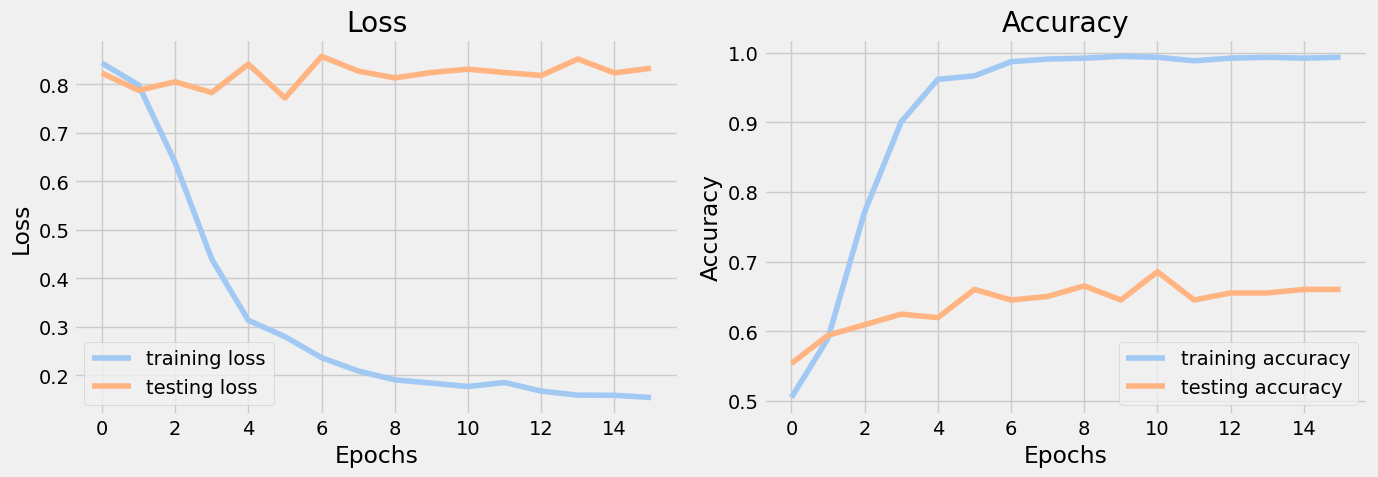

In [65]:
fig, axes = plt.subplots(1,2 , figsize =(14, 5))

sns.lineplot(ax = axes[0], data = history.history['loss'], label = 'training loss' )
sns.lineplot(ax= axes[0], data = history.history['val_loss'], label = 'testing loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

sns.lineplot(ax = axes[1], data = history.history['accuracy'], label = 'training accuracy')
sns.lineplot(ax = axes[1], data = history.history['val_accuracy'], label = 'testing accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

<div style="background-color: #2E7D32 ; color: white; padding: 15px; font-weight: 500; border-radius: 10px; text-align: center; font-family: 'Segoe UI', sans-serif; font-size: 20px;">
    Model Prediction
</div>

In [73]:
def preprocess_input(sentence, tokenizer, maxlen=20):
    remove_spec_char = remove_special_characters(sentence)
    print(remove_spec_char)
    remove_stop_wrod = remove_stopwords(remove_spec_char)
    print(remove_stop_wrod)
    lema_sentence = lemmatize_sentence(remove_stop_wrod)
    print(lema_sentence)

    tokenize_sequence = tokenizer.texts_to_sequences([lema_sentence])
    padded_sequence = pad_sequences(tokenize_sequence, maxlen=maxlen, padding='post', truncating='post')
    
    return padded_sequence

In [78]:
sentence = 'The food was cheap and delicious, and also the service'
padded_input = preprocess_input(sentence, tokenizer, maxlen=20)
prediction = model.predict(padded_input)
print(f"Raw prediction value: {prediction[0][0]}")

# Determine if it's positive or negative
threshold = 0.5
if prediction[0][0] > threshold:
    print("Prediction: Positive")
else:
    print("Prediction: Negative")

The food was cheap and delicious and also the service
food cheap delicious also service
food cheap delicious also service
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Raw prediction value: 0.7031135559082031
Prediction: Positive


In [79]:
sentence = 'what a waste of money'
padded_input = preprocess_input(sentence, tokenizer, maxlen=20)
prediction = model.predict(padded_input)
print(f"Raw prediction value: {prediction[0][0]}")

# Determine if it's positive or negative
threshold = 0.5
if prediction[0][0] > threshold:
    print("Prediction: Positive")
else:
    print("Prediction: Negative")

what a waste of money
waste money
waste money
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Raw prediction value: 0.04685422033071518
Prediction: Negative
